In [25]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from scipy.ndimage import gaussian_filter

from numba import njit
from scipy.signal import savgol_filter

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [4]:
base = '/n/home01/abeane/starbar/plots/bar_prop/data/'

bar_prop_N = h5.File(base + 'bar_prop_Nbody-lvl3.hdf5', mode='r')
bar_prop_S = h5.File(base + 'bar_prop_phantom-vacuum-Sg20-Rc3.5-lvl3.hdf5', mode='r')

In [4]:
sn = read_snap(500, 0, parttype=[1, 2])

halo_pos = sn.part1.pos.value
halo_mass = np.full(sn.NumPart_Total[1], sn.MassTable[1])


In [10]:
agama.Potential?

In [ ]:
pot_halo = agama.Potential(type="Multipole", particles=(pos_halo, mass_halo),
                           symmetry='a', gridsizeR=20, lmax=2)

In [11]:
pot_halo = agama.Potential(type="Multipole", particles=(halo_pos, halo_mass),
                          symmetry='n', gridsizeR=30, lmax=4, mmax=4, nmax=4)

In [14]:
dir(pot_halo)

['Rcirc',
 'Rmax',
 'Rperiapo',
 'Tcirc',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'density',
 'export',
 'force',
 'forceDeriv',
 'name',
 'potential',
 'projectedDensity',
 'projectedForce',
 'sample',
 'totalMass']

In [38]:
# pot_halo.export('data/pot.txt')
pot_halo_nol0 = agama.Potential('data/pot_nol0.txt')

In [39]:
xlist = ylist = np.linspace(-5, 5, 100)
pos = []
for x in xlist:
    for y in ylist:
        pos.append([x, y])
pos = np.array(pos)

In [42]:
dens = pot_halo_nol0.projectedDensity(pos)

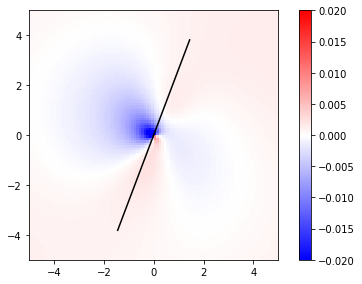

In [53]:
nres = 256

snap = 500
bar_prop = bar_prop_N

range_xy = [[-5, 5], [-5, 5]]

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)
dens = np.reshape(dens, (100, 100))

dens -= np.mean(dens)

im = ax.imshow(dens.T, extent=extent, origin='lower', cmap='bwr', vmin=-0.02, vmax=0.02)#, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')

Rbar = bar_prop['bar_prop']['Rbar'][snap]
ba = bar_prop['bar_angle'][snap]

ax.plot([0, Rbar*np.cos(ba)], [0, Rbar*np.sin(ba)], c='k')
ax.plot([0, Rbar*np.cos(ba + np.pi)], [0, Rbar*np.sin(ba + np.pi)], c='k')

fig.tight_layout()
fig.colorbar(im, ax=ax)

plt.show()


In [5]:
idx_list = np.arange(0, 800, 10)
sn_list = []
for idx in tqdm(idx_list):
    sn_list.append(read_snap(idx, 0, parttype=[1, 2], fields=['Coordinates']))

A Jupyter Widget

In [6]:
@njit
def compute_fourier_component(pos_list, m, Rmax):
    Rmaxsq = Rmax * Rmax
    
    Am_real = 0.0
    Am_imag = 0.0
    
    N = pos_list.shape[0]
    
    for i in range(N):
        pos = pos_list[i]
        
        Rsq = pos[0]*pos[0] + pos[1]*pos[1] + pos[2]*pos[2]
        if Rsq < Rmaxsq:
            phi = np.arctan2(pos[1], pos[0])
            Am_real += np.cos(m*phi)
            Am_imag += np.sin(m*phi)
    
    return Am_real, Am_imag
            

In [8]:
Rmax = 3
m = 2

phi_h_list = []
phi_d_list = []

A2_list = []

for sn in tqdm(sn_list):
    halo_pos = sn.part1.pos.value
    disk_pos = sn.part2.pos.value
    A2r_h, A2i_h = compute_fourier_component(halo_pos, m, Rmax)
    A2r_d, A2i_d = compute_fourier_component(disk_pos, m, Rmax)
    
    phi_h = np.arctan2(A2i_h, A2r_h)
    phi_d = np.arctan2(A2i_d, A2r_d)
    
    phi_h_list.append(phi_h)
    phi_d_list.append(phi_d)
    
    A2_list.append(np.sqrt(A2r_h*A2r_h + A2i_h*A2i_h))
    
phi_h_list = np.array(phi_h_list)
phi_d_list = np.array(phi_d_list)
    

A Jupyter Widget

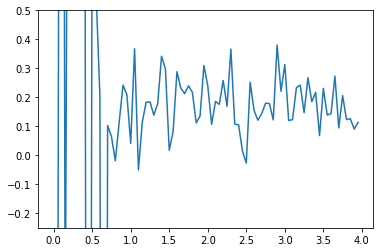

In [30]:
plt.plot(idx_list/200.0, phi_d_list - phi_h_list)
plt.ylim(-0.25, 0.5)
plt.show()

In [31]:
sn_list_S = []
for idx in tqdm(idx_list):
    sn_list_S.append(read_snap(idx, 1, parttype=[1, 2], fields=['Coordinates']))

A Jupyter Widget

In [43]:
Rmax = 3
m = 2

phi_h_S_list = []
phi_d_S_list = []
A2h_s_list = []

center = np.array([200., 200., 200.])

for sn in tqdm(sn_list_S):
    halo_pos = sn.part1.pos.value - center
    disk_pos = sn.part2.pos.value - center
    A2r_h, A2i_h = compute_fourier_component(halo_pos, m, Rmax)
    A2r_d, A2i_d = compute_fourier_component(disk_pos, m, Rmax)
    
    phi_h = np.arctan2(A2i_h, A2r_h)
    phi_d = np.arctan2(A2i_d, A2r_d)
    
    phi_h_S_list.append(phi_h)
    phi_d_S_list.append(phi_d)
    
    A2h_s_list.append(np.sqrt(A2r_h*A2r_h + A2i_h*A2i_h))
    
phi_h_S_list = np.array(phi_h_S_list)
phi_d_S_list = np.array(phi_d_S_list)
    

A Jupyter Widget

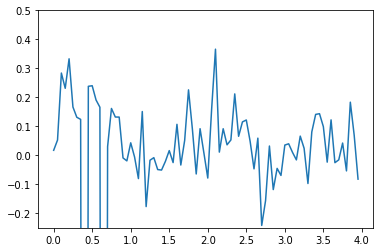

In [46]:
plt.plot(idx_list/200.0, phi_d_S_list - phi_h_S_list)
plt.ylim(-0.25, 0.5)
plt.show()

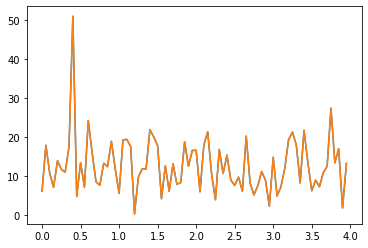

In [42]:
plt.plot(idx_list/200.0, A2h_s_list)
plt.show()

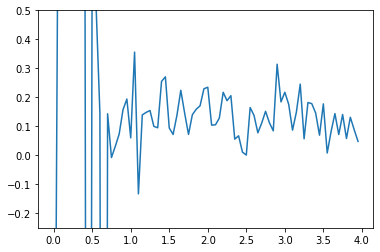

In [9]:
# TEMPORARY
plt.plot(idx_list/200.0, phi_d_list - phi_h_list)
plt.ylim(-0.25, 0.5)
plt.show()

## Plot fourier component angle diff

In [9]:
base = '/n/home01/abeane/starbar/plots/fourier_sphere/data/'

fourierN = h5.File(base + 'fourier_Nbody-lvl3.hdf5', mode='r')
fourierS = h5.File(base + 'fourier_phantom-vacuum-Sg20-Rc3.5-lvl3.hdf5', mode='r')

In [30]:
phi_N = np.arctan2(fourierN['A2i'], fourierN['A2r'])
phi_Nh = np.arctan2(fourierN['A2i_h'], fourierN['A2r_h'])

phi_S = np.arctan2(fourierS['A2i'], fourierS['A2r'])
phi_Sh = np.arctan2(fourierS['A2i_h'], fourierS['A2r_h'])

In [12]:
phi_N

array([-0.74982371, -0.04162906,  0.49031223, ...,  0.25493797,
        0.42690771,  0.60358462])

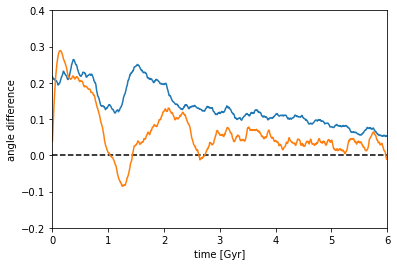

In [39]:
dphiN = phi_N - phi_Nh
dphiN = np.mod(dphi + np.pi, 2.*np.pi) - np.pi
tN = fourierN['time'][:]
yN = savgol_filter(dphi, 81, 3)

dphiS = phi_S - phi_Sh
dphiS = np.mod(dphiS + np.pi, 2.*np.pi) - np.pi
tS = fourierS['time'][:]
yS = savgol_filter(dphiS, 81, 3)

# plt.plot(t, dphi)
plt.axhline(0.0, c='k', ls='dashed')

plt.plot(tN - tN[300], yN)
plt.plot(tS, yS)


plt.ylim(-0.2, 0.4)
plt.xlim(0, 6)
plt.xlabel('time [Gyr]')
plt.ylabel('angle difference')
plt.show()

In [40]:
idx_list = np.arange(0, 1200)

torque_path = '/n/home01/abeane/starbar/plots/torques/data'
gas_base = torque_path + '/torques_phantom-vacuum-Sg20-Rc3.5-lvl3/torques_phantom-vacuum-Sg20-Rc3.5-lvl3.'
rstHalo_base = torque_path + '/torques_phantom-vacuum-Sg20-Rc3.5-lvl3-rstHalo/torques_phantom-vacuum-Sg20-Rc3.5-lvl3-rstHalo.'
N_base = torque_path + '/torques_Nbody-lvl3/torques_Nbody-lvl3.'

tz_halo = []
tz_not_bar = []
tz_gas = []
time = []

tz_halo_rH = []
tz_not_bar_rH = []
tz_gas_rH = []
time_rH = []

tz_haloN = []
tz_not_barN = []

for idx in tqdm(idx_list):
#     sn = read_snap(idx, 1, parttype=[0], fields=['Masses'])
    
    fname = gas_base + str(idx) + '.hdf5'
    
    t = h5.File(fname, mode='r')
    
#     torque_halo = sn.MassTable[1].value * np.cross(np.array(t['pos_halo']), np.array(t['acc_halo']))
    torque_halo = t['total_torques'].attrs['halo']
    tz_halo.append(torque_halo[2])
    
#     torque_not_bar = sn.MassTable[2].value * np.cross(np.array(t['pos_notbar']), np.array(t['acc_notbar']))
    torque_not_bar = t['total_torques'].attrs['not_bar']
    tz_not_bar.append(torque_not_bar[2])
    
#     torque_gas = my_mult(sn.part0.mass.value, np.cross(np.array(t['pos_gas']), np.array(t['acc_gas'])))
    torque_gas = t['total_torques'].attrs['gas']
    tz_gas.append(torque_gas[2])
    
    time.append(t['parameters'].attrs['Time'])
    
    t.close()


    
    
    fname = N_base + str(idx) + '.hdf5'
    t = h5.File(fname, mode='r')
    
    torque_halo = t['total_torques'].attrs['halo']
    tz_haloN.append(torque_halo[2])
    
    torque_not_bar = t['total_torques'].attrs['not_bar']
    tz_not_barN.append(torque_not_bar[2])
    
    
#     time.append(t['parameters'].attrs['Time'])
    
    t.close()
    
    try:
#     if True:
        fname = rstHalo_base + str(idx) + '.hdf5'
        t = h5.File(fname, mode='r')
        
        time_rH.append(t['parameters'].attrs['Time'])
    
        torque_halo = t['total_torques'].attrs['halo']
        tz_halo_rH.append(torque_halo[2])
    
        torque_not_bar = t['total_torques'].attrs['not_bar']
        tz_not_bar_rH.append(torque_not_bar[2])
        
        torque_gas = t['total_torques'].attrs['gas']
        tz_gas_rH.append(torque_gas[2])
    
    
        t.close()
    except:
#         print(idx)
        pass
    

tz_halo = np.array(tz_halo)
tz_not_bar = np.array(tz_not_bar)
tz_gas = np.array(tz_gas)

tz_halo_rH = np.array(tz_halo_rH)
tz_not_bar_rH = np.array(tz_not_bar_rH)
tz_gas_rH = np.array(tz_gas_rH)

tz_haloN = np.array(tz_haloN)
tz_not_barN = np.array(tz_not_barN)

time = np.array(time)

A Jupyter Widget

KeyboardInterrupt: 